# Facial Similarity with Siamese network and LFW dataset

In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

### DataLoader

In [19]:
class LFWDataset(Dataset):
    def __init__(self, pairs_file, img_folder, transform=None):
        self.pairs_file = pairs_file
        self.img_folder = img_folder
        self.transform = transform
        self.image_pairs, self.labels = self._load_pairs()


    def _load_pairs(self):
        with open(self.pairs_file, 'r') as f:
            pairs = f.readlines()[1:]
        image_pairs = []
        labels = []

        for pair in pairs:
            pair = pair.strip().split()
            if len(pair) == 3:
                person = pair[0]
                img_1 = os.path.join(self.img_folder, person, f"{person}_{int(pair[1]):04d}.jpg")
                img_2 = os.path.join(self.img_folder, person, f"{person}_{int(pair[2]):04d}.jpg")
                label = 1
            else:
                person_1 = pair[0]
                person_2 = pair[2]
                img_1 = os.path.join(self.img_folder, person_1, f"{person_1}_{int(pair[1]):04d}.jpg")
                img_2 = os.path.join(self.img_folder, person_2, f"{person_2}_{int(pair[3]):04d}.jpg")
                label = 0

            image_pairs.append((img_1, img_2))
            labels.append(label)

        return image_pairs, labels
    

    def __getitem__(self, index):
        path_img_1, path_img_2 = self.image_pairs[index]
        label = self.labels[index]

        img_1 = Image.open(path_img_1).convert("RGB")
        img_2 = Image.open(path_img_2).convert("RGB")

        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)

        return img_1, img_2, torch.tensor([label], dtype=torch.float32)
    

    def __len__(self):
        return len(self.image_pairs)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

lfw_dataset = LFWDataset(pairs_file='/home/mehran/Documents/Datasets/pairsDevTrain.txt', img_folder='/home/mehran/Documents/Datasets/lfw-deepfunneled', transform=transform)
train_loader = torch.utils.data.DataLoader(lfw_dataset, batch_size=32, shuffle=True)


### Siamese Network Architecture

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x
    
    def forward(self, input_1, input_2):
        output_1 = self.forward_once(input_1)
        output_2 = self.forward_once(input_2)
        return output_1, output_2
    

model = SiameseNetwork()

### Loss Function(Contrastive Loss)

In [21]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    
    def forward(self, output_1, output_2, label):
        euclidean_distance = nn.functional.pairwise_distance(output_1, output_2)
        loss_contrastive = torch.mean(
        (1 - label) * torch.pow(euclidean_distance, 2) +
        label * torch.pow(torch.clamp(
            self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive
    

criterion = ContrastiveLoss()

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10
def train(model, train_loader, criterion, optimizer, num_epochs=EPOCHS):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for img_1, img_2, label in train_loader:
            # img_1, img_2, label = img_1.cuda(), img_2.cuda(), label.cuda()
            optimizer.zero_grad()
            output_1, output_2 = model(img_1, img_2)
            loss = criterion(output_1, output_2, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
train(model, train_loader, criterion, optimizer)

Epoch [1/10], Loss: 5.3184
Epoch [2/10], Loss: 0.2663
Epoch [3/10], Loss: 0.2606
Epoch [4/10], Loss: 0.2569
Epoch [5/10], Loss: 0.2566
Epoch [6/10], Loss: 0.2556
Epoch [7/10], Loss: 0.2564
Epoch [8/10], Loss: 0.2552
Epoch [9/10], Loss: 0.2544
Epoch [10/10], Loss: 0.2556


### Test the Model on Two Images

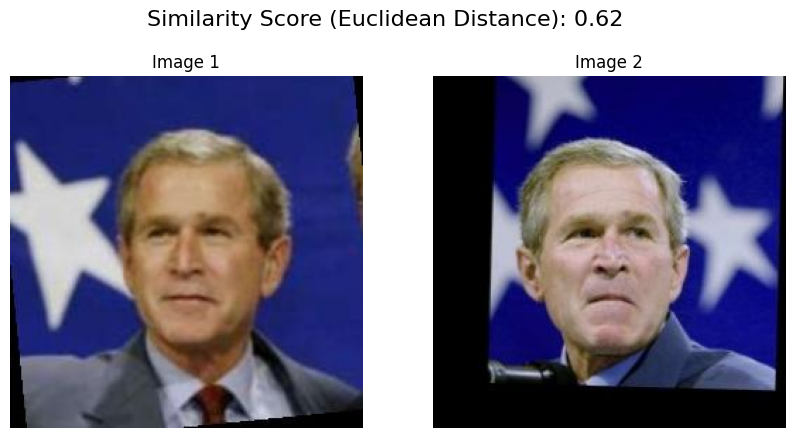

In [24]:
def show_result(model, img1_path, img2_path, transform):

    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")

    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output1, output2 = model(img1, img2)

    euclidean_distance = nn.functional.pairwise_distance(output1, output2).item()

    img1 = np.array(Image.open(img1_path))
    img2 = np.array(Image.open(img2_path))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].set_title('Image 1')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].set_title('Image 2')

    plt.suptitle(f'Similarity Score (Euclidean Distance): {euclidean_distance:.2f}', fontsize=16)
    plt.show()

path_img_1 = '/home/mehran/Documents/Datasets/lfw-deepfunneled/George_W_Bush/George_W_Bush_0001.jpg'
path_img_2 = '/home/mehran/Documents/Datasets/lfw-deepfunneled/George_W_Bush/George_W_Bush_0002.jpg'

show_result(model, path_img_1, path_img_2, transform)
